In [2]:
from __future__ import print_function
import pandapower as pp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import stable_baselines
import pickle
from stable_baselines import DDPG
import sys
import copy
sys.path.append('C:\\Users\\vegar\\Dropbox\\Master\\thesis.git')
from  gym_power.envs.active_network_env import ActiveEnv
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib notebook


# I need to see the actions of the agent
The agent activates flexibility to help the net. Need to plot the actions of the agent togeather with solar irradiance and demand at each load.


In [195]:
def pickle_savefig(fig,figname):
    matplotlib_name = 'figs/' + figname + '_plt.p'
    with open(matplotlib_name,'wb') as f:
        pickle.dump(fig,f)
    fig.savefig('figs/' + figname +'.png')
    
    
    
    

In [196]:
def read_pickle_fig(figname):
    with open('figs/'+figname +'_plt.p', 'rb') as f:
        fig = pickle.load(f)
    return fig

In [3]:
def find_load_names(sol_bus):
    nr_sol = 1
    nr_else = 1
    load_names = []
    for k in range(len(sol_bus)):
        if sol_bus[k]:
            load_names.append('sun {}'.format(nr_sol))
            nr_sol += 1
        else:
            load_names.append('load {}'.format(nr_else))
            nr_else += 1
    return load_names

In [4]:
def simulate_day2(env,model, show_imbalance=False, show_solar=True, show_action=True,
                  show_demand=False,period=25):
    net = env.powergrid
    sol_bus = net.load['bus'].isin(net.sgen['bus'])
    actions = []
    t_steps = []
    flex_loads = []
    sols = []
    obs = env.reset()
    sol = env.solar_forecasts
    demand = env.demand_forecasts[0]
    names = find_load_names(sol_bus)
    hues = []
    for t_step in range(1,period):
        
        action,_ = model.predict(obs)
        obs, rewards, dones, info = env.step(action)
        
        if show_action:
            actions += list(action)
            hues += ['action' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        
        if show_solar:
            actions += list(sol[t_step-1]*np.ones_like(action))
            hues += ['sun' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
        if show_imbalance:
            try:
                imbalance = env.calc_balance()/30000
            except AttributeError:
                imbalance = env.calc_imbalance()/30000
            actions += list(imbalance*np.ones_like(action))
            hues += ['imbalance' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            
        if show_demand:
            actions += list(demand[t_step-1]*np.ones_like(action))
            hues += ['demand' for _ in range(len(action))]
            t_steps += list(t_step*np.ones_like(action))
            flex_loads += names
            


    df = pd.DataFrame()
    df['actions'] = actions
    df['steps'] = t_steps
    df['load'] = flex_loads
    df[''] = hues
    return df

In [5]:
def data_from_subplot(ax, imbalance=False):
    actions = ax.lines[3].get_ydata()
    sun = ax.lines[4].get_ydata()
    balance = ax.lines[5].get_ydata()
    oneplot = pd.DataFrame()
    if imbalance:
        oneplot['Energy imbalance'] = balance
    oneplot['Solar irradiance'] = sun
    oneplot['Action'] = actions
    return oneplot

## Import models

In [6]:
def load_env(model_name='flexible_load_first',seed=9):
#flexible_load_first, overnight, larger_margin_cost, discount_06, flex50

    params_name = model_name +'_params.p'
    model = DDPG.load('models/'+model_name)
    env = ActiveEnv(seed=seed)
    with open('models/' + params_name,'rb') as f:
        params = pickle.load(f)

    env.set_parameters(params)
    model.set_env(env)
    return model, env

In [7]:
model, env = load_env()

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


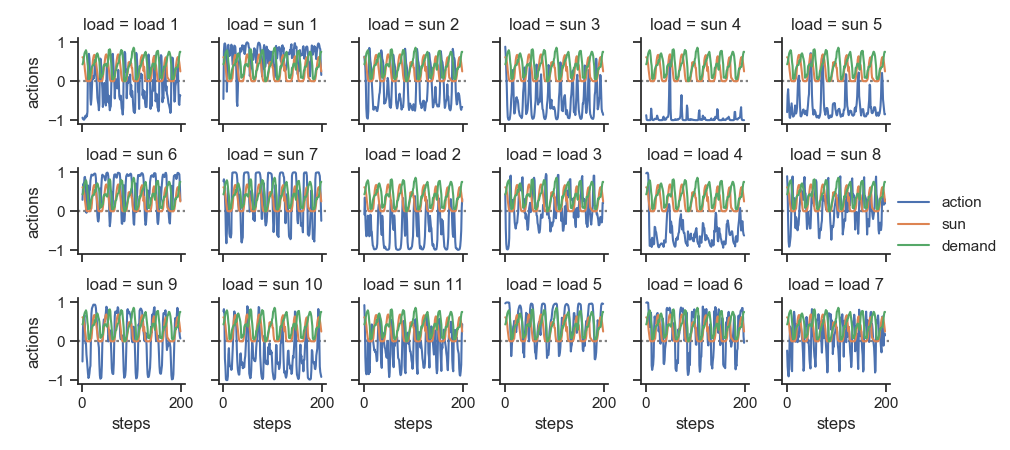

In [24]:
df = simulate_day2(env,model, show_demand=True, period=199)
sns.set(style="ticks")

grid = sns.FacetGrid(df, col="load", hue="",
                     col_wrap=6, height=1.5)

grid.map(plt.axhline, y=0, ls=":", c=".5")

grid.map(plt.plot, "steps", "actions")
grid.add_legend()



In [27]:
env.powergrid.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,Load R1,1,11130.235669,2346.309447,0.0,0.0,15300.0,1.0,True,None
1,Load R3,3,218.676550,53.943511,0.0,0.0,285.0,1.0,True,None
2,Load R4,4,313.859202,84.227587,0.0,0.0,445.0,1.0,True,None
3,Load R5,5,517.537331,141.956607,0.0,0.0,750.0,1.0,True,None
4,Load R6,6,384.029546,106.940644,0.0,0.0,565.0,1.0,True,None
5,Load R8,8,418.078069,114.511663,0.0,0.0,605.0,1.0,True,None
6,Load R10,10,380.178290,92.744983,0.0,0.0,490.0,1.0,True,None
7,Load R11,11,250.476477,64.353662,0.0,0.0,340.0,1.0,True,None
8,Load R12,12,11919.536178,2346.309447,0.0,0.0,15300.0,1.0,True,None
9,Load R14,14,165.839170,40.694227,0.0,0.0,215.0,1.0,True,None


In [29]:
@interact
def plot_load(ax_nr1=range(18),ax_nr2=range(18),period=(0,200)):
    plot1 = data_from_subplot(grid.axes[ax_nr1],imbalance=True)
    plot2 = data_from_subplot(grid.axes[ax_nr2],imbalance=True)

    fig, axes = plt.subplots(2)
    #axes.set_title(ax.get_title())
    #axes.set_title('Total energy imbalance')
    axes[0].set_xlabel('steps')
    axes[0].axhline(0,c=".5",ls='--')
    axes[1].axhline(0,c=".5",ls='--')
    #axes.set_ylabel('MWh')
    plot1[:period].plot(ax=axes[0])
    plot2[:period].plot(ax=axes[1])
    plt.tight_layout()


interactive(children=(Dropdown(description='ax_nr1', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14…

## See resulting voltages etc

In [42]:
env.powergrid.res_bus

,vm_pu,va_degree,p_kw,q_kvar
0,1.030000,0.000000,-29900.456517,-9086.961999
1,1.009357,-3.664185,11333.733241,2933.480999
2,0.996422,-4.237402,0.000000,0.000000
3,0.975807,-5.144488,330.646468,144.530961
4,0.974814,-5.196491,322.639727,68.400152
5,0.974195,-5.227244,361.806933,115.281155
6,0.973481,-5.262905,262.167977,86.845137
7,0.972465,-5.277896,63.411203,34.208192
8,0.972660,-5.268847,385.352659,92.993465
9,0.972120,-5.286005,311.028317,256.561444


In [35]:
period=199
model, env = load_env(seed=9)
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
sol = env.solar_forecasts
hues = []
env.set_parameters({'flexibility':0.25,
                   'solar_scale':1.2})
env2 = copy.deepcopy(env)
env2.do_action = False

for t_step in range(1,period):

    #action,_ = model.predict(obs)
    action2 = -np.ones(18)
    obs1, rewards1, dones1, info1 = env.step(action2)
    
    obs2, rewards2, dones2, info2 = env2.step(action2)
    
    #if env.powergrid.res_bus.vm_pu.max() > 1.05:
    #    break
    v_agent = env.powergrid.res_bus.vm_pu
    actions += list(v_agent)
    hues += ['-25% demand' for _ in range(len(v_agent))]
    t_steps += list(t_step*np.ones_like(v_agent))
    flex_loads += list(range(len(v_agent)))
    
    
    v_no_action = env2.powergrid.res_bus.vm_pu
    actions += list(v_no_action)
    hues += ['No agent' for _ in range(len(v_no_action))]
    t_steps += list(t_step*np.ones_like(v_no_action))
    flex_loads += list(range(len(v_agent)))

df = pd.DataFrame()
df['Voltage [pu]'] = actions
df['Hours'] = t_steps
df['Load'] = flex_loads
df[''] = hues

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


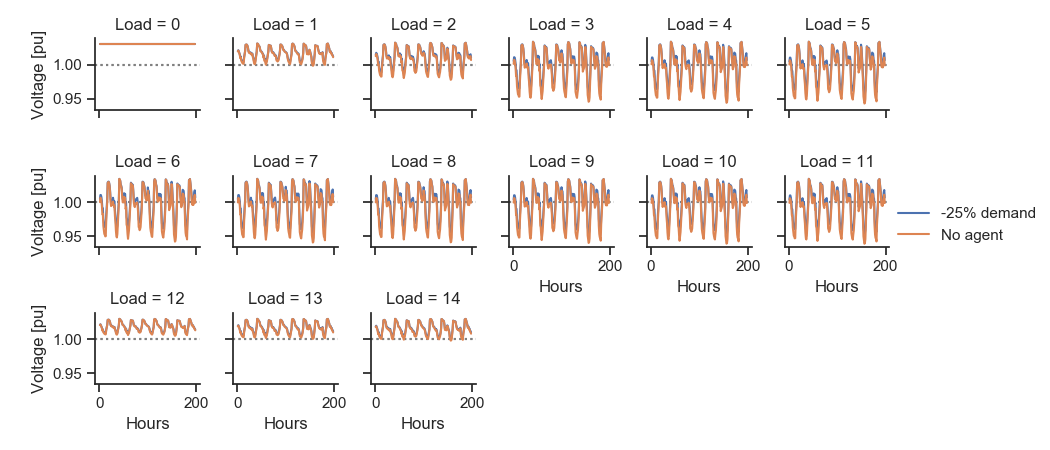

In [36]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Load", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hours", "Voltage [pu]")
grid.add_legend()



In [37]:
@interact
def plot_voltage(bus_nr=list(range(15))[::-1]):
    data = df[df['Load']== bus_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hours", y="Voltage [pu]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='bus_nr', options=(14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0…

In [134]:
def change_hours(x,start=155):
    return x-start
def change_legend(x):
    if x == 'No agent':
        return 'No action'
    else:
        return x

<IPython.core.display.Javascript object>


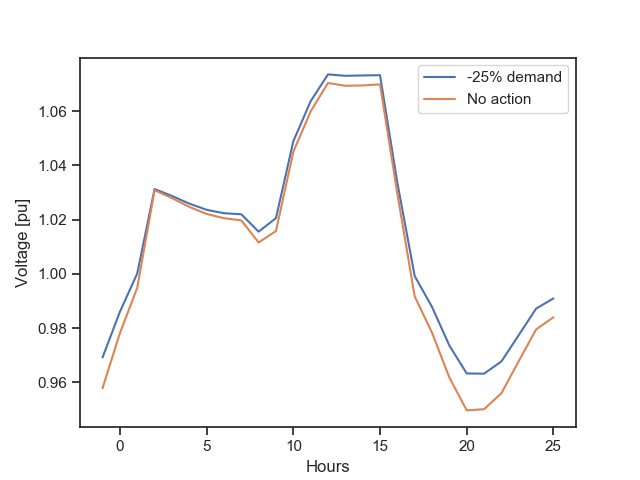

In [106]:
data = df[df['Load']== 8]
data = data[data['Hours'].isin(range(156,183))]
data[''] = data[''].apply(lambda x:change_legend(x))
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x,start=157))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Voltage [pu]", data=data, ax=ax, hue='')

In [107]:
#fig.savefig('figs/decrease_demand_voltage.png')

In [77]:
env.powergrid.load

,name,bus,p_kw,q_kvar,const_z_percent,const_i_percent,sn_kva,scaling,in_service,type
0,Load R1,1,1663.952860,270.304031,0.0,0.0,15300.0,1.0,True,None
1,Load R3,3,30.995200,6.214504,0.0,0.0,285.0,1.0,True,None
2,Load R4,4,48.396015,9.703348,0.0,0.0,445.0,1.0,True,None
3,Load R5,5,81.566317,16.353957,0.0,0.0,750.0,1.0,True,None
4,Load R6,6,61.446625,12.319981,0.0,0.0,565.0,1.0,True,None
5,Load R8,8,65.796829,13.192192,0.0,0.0,605.0,1.0,True,None
6,Load R10,10,53.289994,10.684585,0.0,0.0,490.0,1.0,True,None
7,Load R11,11,36.976730,7.413794,0.0,0.0,340.0,1.0,True,None
8,Load R12,12,1663.952860,270.304031,0.0,0.0,15300.0,1.0,True,None
9,Load R14,14,23.382344,4.688134,0.0,0.0,215.0,1.0,True,None


## Line capacity effect

In [78]:
period=199
model, env = load_env(seed=8)
net = env.powergrid
actions = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env.set_parameters({'solar_scale': 1.2,
                    'flexibility':0.25})
env2 = copy.deepcopy(env)
env2.do_action = False



for t_step in range(1,period):

    action,_ = model.predict(obs)
    action2 = np.ones(18)
    action2[[0,10]] = -1

    obs1, rewards1, dones1, info1 = env.step(action2)
    obs2, rewards2, dones2, info2 = env2.step(action2)
    
    
    i_agent = env.powergrid.res_line['loading_percent']
    actions += list(i_agent)
    hues += ['+ 25 % demand' for _ in range(len(i_agent))]
    t_steps += list(t_step*np.ones_like(i_agent))
    flex_loads += list(range(len(i_agent)))
    
    
    i_no_agent = env2.powergrid.res_line['loading_percent']
    actions += list(i_no_agent)
    hues += ['No actions' for _ in range(len(i_no_agent))]
    t_steps += list(t_step*np.ones_like(i_no_agent))
    flex_loads += list(range(len(i_no_agent)))

df = pd.DataFrame()
df['Line capacity [%]'] = actions
df['Hours'] = t_steps
df['Line'] = flex_loads
df[''] = hues

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


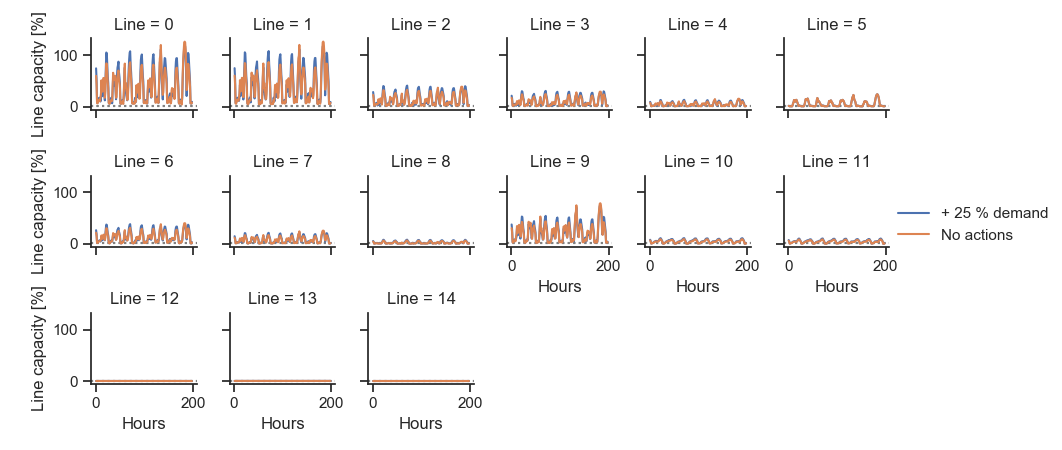

In [79]:
sns.set(style="ticks")
grid = sns.FacetGrid(df, col="Line", hue="",
                     col_wrap=6, height=1.5)


grid.map(plt.axhline, y=1, ls=":", c=".5")

grid.map(plt.plot, "Hours", "Line capacity [%]")
grid.add_legend()



In [80]:
@interact
def plot_current(line_nr=list(range(15))):
    data = df[df['Line']== line_nr]
    fig, ax = plt.subplots()
    sns.lineplot(x="Hours", y="Line capacity [%]", data=data, ax=ax, hue='')
    


interactive(children=(Dropdown(description='line_nr', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

<IPython.core.display.Javascript object>


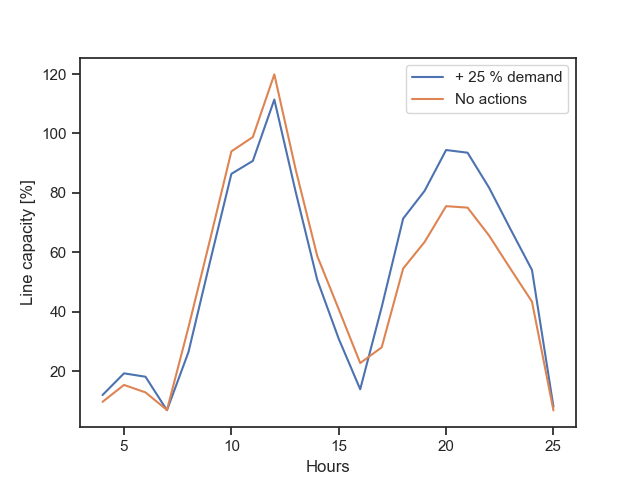

In [82]:
data = df[df['Line']== 0]
data = data[data['Hours'].isin(range(126,148))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=122))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Line capacity [%]", data=data, ax=ax, hue='')
#fig.savefig('figs/increase_demand_current.png')

## See the difference in reward between agent and no-agent

In [107]:
period=20000
model, env = load_env(seed=9) #seed 5: heavy sun, 9: weak sun
env.set_parameters({'reward_terms': ['voltage']})
net = env.powergrid
rewards = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False
sol = env.solar_forecasts
demand = env.demand_forecasts[0]

show_sun = True
show_demand = True
for t_step in range(1,period):

    action,_ = model.predict(obs)
    obs1, reward1, dones1, info1 = env.step(action)
    obs2, reward2, dones2, info2 = env2.step(action)
    if env._current_step == 0:
        sol = env.solar_forecasts
        demand = env.demand_forecasts[0]
        env2.demand_forecasts = env.demand_forecasts

    
    rewards.append(reward1)
    hues.append('Agent')
    t_steps.append(t_step)
    
    rewards.append(reward2)
    hues.append('No agent')
    t_steps.append(t_step)
    
    if show_sun:    
        rewards.append(sol[env._current_step-1])
        hues.append('Sun')
        t_steps.append(t_step)
        
    if show_demand:
        rewards.append(demand[env._current_step-1])
        hues.append('Demand')
        t_steps.append(t_step)

df = pd.DataFrame()
df['Reward'] = rewards
df['Hours'] = t_steps
df[''] = hues

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


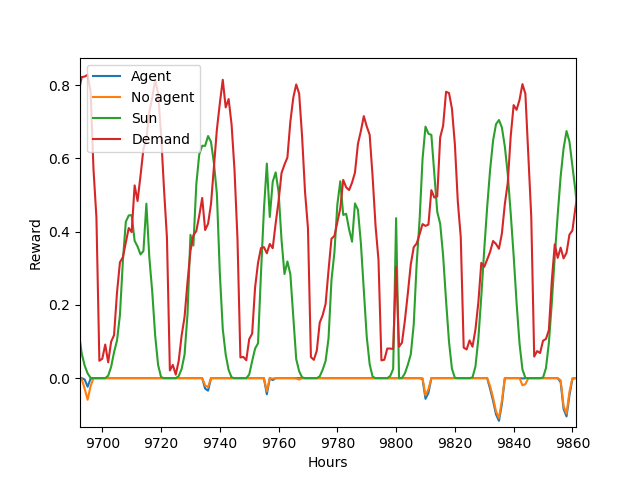

In [213]:
fig,ax = plt.subplots()
sns.lineplot(x='Hours',y='Reward',data=df,hue='', ax=ax)

In [209]:
rewards = df[df[''].isin(['Agent','No agent'])]
rewards = rewards[rewards['Reward'] < 0]
stats = rewards[['','Reward']].groupby(['']).describe()['Reward']
stats
#stats.iloc[:,:-1].to_csv('data/stats_100episodes_config1.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,1435.0,-0.034549,0.036551,-0.185636,-0.053644,-0.021224,-0.005808,-0.000002
No agent,1824.0,-0.036161,0.036847,-0.207405,-0.055619,-0.023894,-0.006603,-0.000002


<IPython.core.display.Javascript object>


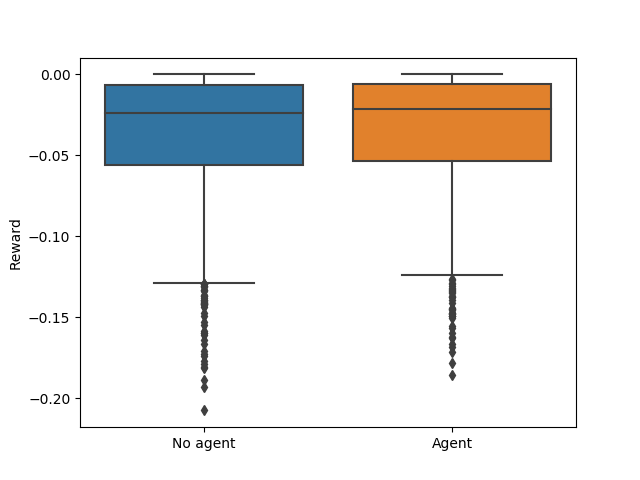

In [212]:
fig, ax = plt.subplots()
sns.boxplot(x="", y="Reward", data=rewards, ax=ax)

## Period the agent is good

<IPython.core.display.Javascript object>


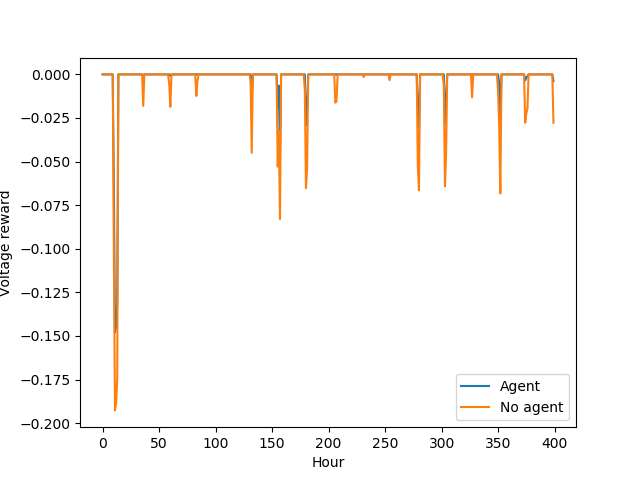

Text(0.5, 0, 'Hour')

In [198]:
rewards = df[df[''].isin(['Agent','No agent'])]
data = rewards
data = data[data['Hours'].isin(range(15600,16000))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=15600))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [199]:
#pickle_savefig(fig,'config1_400hour_good_voltage')

In [214]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_400hour_good_voltage.csv',float_format='%.3f')


,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,23.0,-0.033103,0.045647,-0.147794,-0.031007,-0.019156,-0.003638,-0.000061
No agent,37.0,-0.042013,0.050395,-0.192663,-0.054068,-0.022295,-0.008945,-0.000738


## Periods the agent is bad in terms of voltage
The agent has not learned to cope with high solar power production, period with high solar production have been found manually

<IPython.core.display.Javascript object>


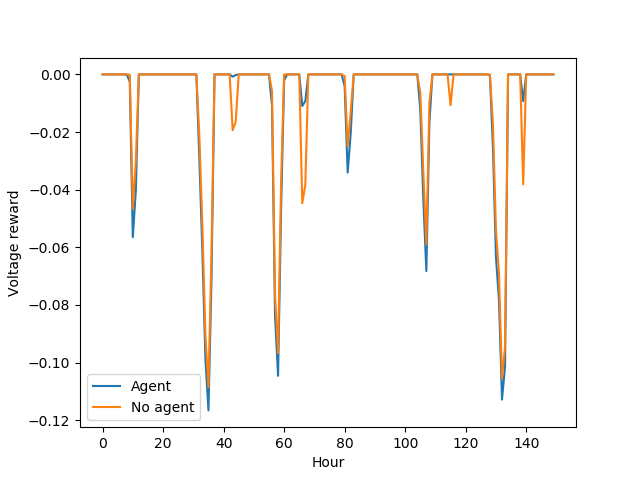

Text(0.5, 0, 'Hour')

In [221]:
rewards = df[df[''].isin(['Agent','No agent'])]
data = rewards
data = data[data['Hours'].isin(range(9800,9950))]
data['Hours'] = data['Hours'].apply(lambda x:change_hours(x, start=9800))
fig, ax = plt.subplots()
sns.lineplot(x="Hours", y="Reward", data=data, ax=ax, hue='')
ax.set_ylabel('Voltage reward')
ax.set_xlabel('Hour')

In [224]:
stats = data[data['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/config1_150hour_bad_voltage.csv',float_format='%.3f')

# Simulate many episodes

In [222]:
#pickle_savefig(fig,'config1_150hour_bad_voltage')

In [169]:
period=10000
model, env = load_env(seed=9)
env.set_parameters({'reward_terms': ['voltage'],
                   'flexibility':0.1})
net = env.powergrid
rewards = []
t_steps = []
flex_loads = []
obs = env.reset()
hues = []
env2 = copy.deepcopy(env)
env2.do_action = False
sol = env.solar_forecasts
demand = env.demand_forecasts[0]

show_sun = False
show_demand = False
for t_step in range(1,period):
    
    if env._current_step == 0:
        sol = env.solar_forecasts
        demand = env.demand_forecasts[0]
        env2.demand_forecasts = env.demand_forecasts

    action,_ = model.predict(obs)
    obs1, reward1, dones1, info1 = env.step(action)
    obs2, reward2, dones2, info2 = env2.step(action)
    
    
    rewards.append(reward1)
    hues.append('Agent')
    t_steps.append(t_step)
    
    rewards.append(reward2)
    hues.append('No agent')
    t_steps.append(t_step)
    
    if show_sun:    
        rewards.append(sol[t_step-1])
        hues.append('Sun')
        t_steps.append(t_step)
        
    if show_demand:
        rewards.append(demand[t_step-1])
        hues.append('Demand')
        t_steps.append(t_step)

df = pd.DataFrame()
df['Reward'] = rewards
df['Hours'] = t_steps
df[''] = hues

Loading a model without an environment, this model cannot be trained until it has a valid environment.
setting up target updates ...
  target/pi/fc0/kernel:0 <- model/pi/fc0/kernel:0
  target/pi/fc0/bias:0 <- model/pi/fc0/bias:0
  target/pi/LayerNorm/beta:0 <- model/pi/LayerNorm/beta:0
  target/pi/LayerNorm/gamma:0 <- model/pi/LayerNorm/gamma:0
  target/pi/fc1/kernel:0 <- model/pi/fc1/kernel:0
  target/pi/fc1/bias:0 <- model/pi/fc1/bias:0
  target/pi/LayerNorm_1/beta:0 <- model/pi/LayerNorm_1/beta:0
  target/pi/LayerNorm_1/gamma:0 <- model/pi/LayerNorm_1/gamma:0
  target/pi/pi/kernel:0 <- model/pi/pi/kernel:0
  target/pi/pi/bias:0 <- model/pi/pi/bias:0
  target/qf/fc0/kernel:0 <- model/qf/fc0/kernel:0
  target/qf/fc0/bias:0 <- model/qf/fc0/bias:0
  target/qf/LayerNorm/beta:0 <- model/qf/LayerNorm/beta:0
  target/qf/LayerNorm/gamma:0 <- model/qf/LayerNorm/gamma:0
  target/qf/fc1/kernel:0 <- model/qf/fc1/kernel:0
  target/qf/fc1/bias:0 <- model/qf/fc1/bias:0
  target/qf/LayerNorm_1/beta:

<IPython.core.display.Javascript object>


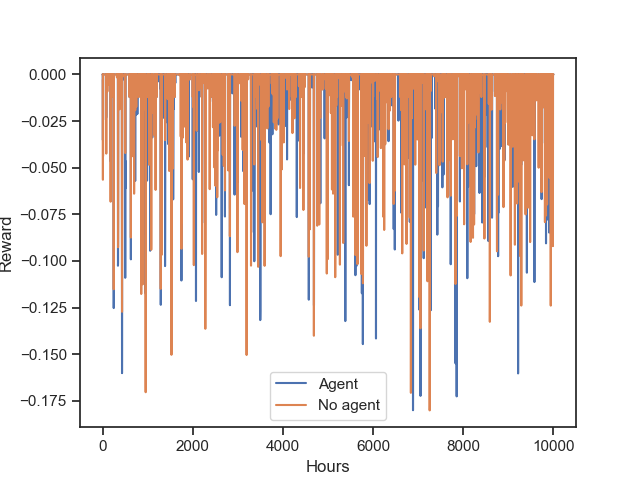

In [170]:
fig,ax = plt.subplots()
sns.lineplot(x='Hours',y='Reward',data=df,hue='', ax=ax)

In [10]:
df = pd.read_csv('data/50_episodes_voltage.csv')
df = df.rename(columns={'Unnamed: 3':''}).iloc[:,1:]
stats = df[df['Reward'] < 0].groupby('')['Reward'].describe()
stats
#stats.iloc[:,:-1].to_csv('data/stats_50episodes_config1.csv',float_format='%.3f')

,count,mean,std,min,25%,50%,75%,max
,,,,,,,,
Agent,817.0,-0.034336,0.036653,-0.180035,-0.055077,-0.019047,-0.005828,-0.000004
No agent,900.0,-0.033247,0.034404,-0.180135,-0.050343,-0.018764,-0.007123,-0.000009


<IPython.core.display.Javascript object>


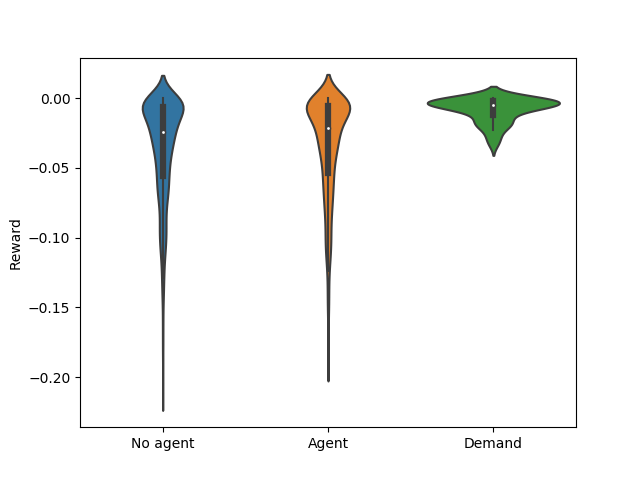

In [202]:
fig, ax = plt.subplots()
sns.violinplot(x="", y="Reward", data=df[df['Reward']<0], ax=ax)

## Pull out values where no-agent is punished and sort values

In [26]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] < 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])

<IPython.core.display.Javascript object>


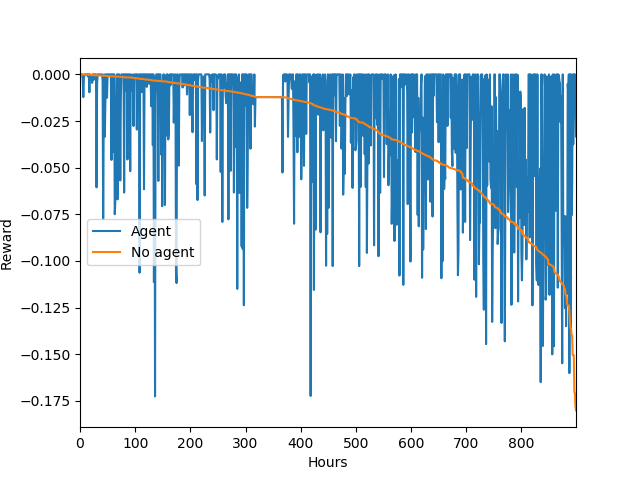

Text(0, 0.5, 'Reward')

In [14]:
fig, ax = plt.subplots()
sorted_agent = bad_agent.sort_values(by='No agent',ascending=False)
sorted_agent = sorted_agent.reset_index()
sorted_agent.plot(y=['Agent','No agent'],ax=ax)
ax.set_xlabel('Hours')
ax.set_ylabel('Reward')

In [15]:
def stack_columns(df,columns):
    stacked = pd.DataFrame()
    values, labels = [], []
    for col in columns:
        values += list(df[col])
        labels += [col for _ in range(len(df))]
    stacked['Reward'] = values
    stacked[''] = labels
    return stacked
    

<IPython.core.display.Javascript object>


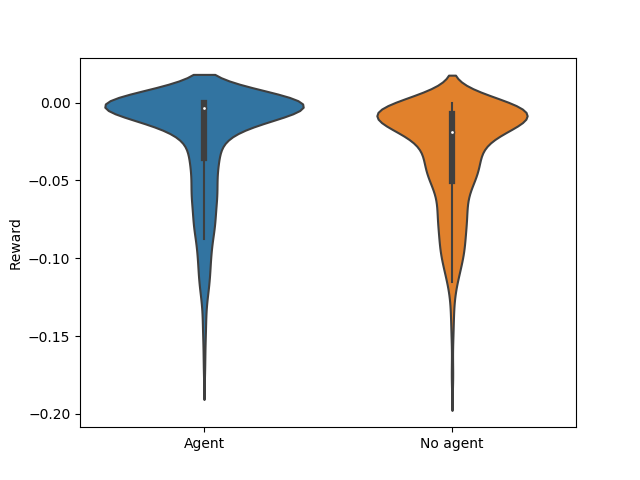

In [16]:
stacked = stack_columns(sorted_agent,['Agent', 'No agent'])
fig, ax = plt.subplots()
sns.violinplot(x='', y="Reward", data=stacked, ax=ax)

In [17]:
stats = stacked.groupby('')['Reward'].describe()
#stats.iloc[:,:-1].to_csv('data/stats_50episodes_preventive_config1.csv',float_format='%.3f')

In [390]:
#fig.savefig('figs/violin_voltage_reward_config1.png')

### Statistics for trained agent's preventive abilities 

In [355]:
stats_bad = bad_agent[['Agent','No agent']].describe().T
stats_bad

,count,mean,std,min,25%,50%,75%,max
Agent,900.0,-0.023184,0.035338,-0.172628,-0.035299,-0.003725,0.000000,0.000000
No agent,900.0,-0.033247,0.034404,-0.180135,-0.050343,-0.018764,-0.007123,-0.000009


In [290]:
#fig.savefig('figs/sorted_reward_voltage_config1.png')

##  Cumulative sum the sorted rewards for agent and no-agent

<IPython.core.display.Javascript object>


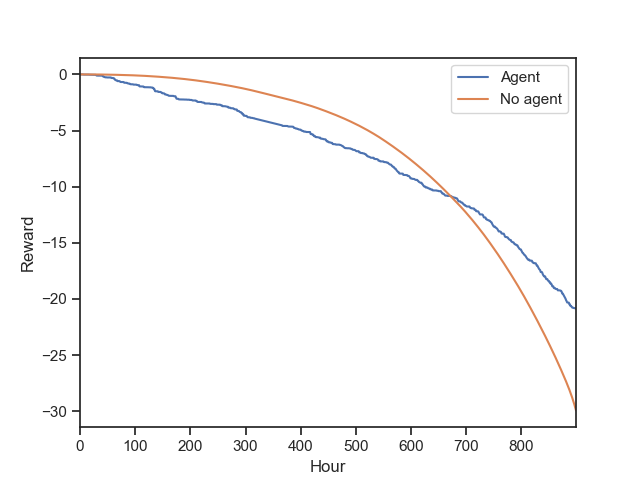

Text(0.5, 0, 'Hour')

In [247]:
fig, ax = plt.subplots()
sorted_agent[['Agent','No agent']].cumsum().plot(ax=ax)
ax.set_ylabel('Reward')
ax.set_xlabel('Hour')

<IPython.core.display.Javascript object>


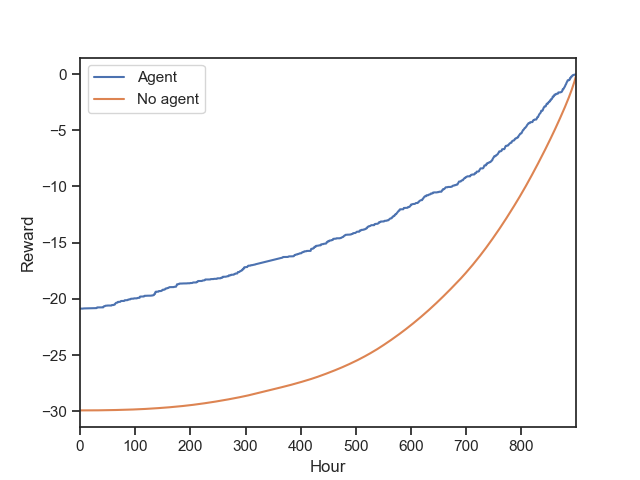

Text(0.5, 0, 'Hour')

In [248]:
fig, ax = plt.subplots()
sorted_agent[['Agent','No agent']][::-1].cumsum().plot(ax=ax)
ax.set_ylabel('Reward')
ax.set_xlabel('Hour')

In [249]:
sorted_agent.describe()

,index,Agent,Hours,No agent,normal_hours
count,900.000000,900.000000,900.000000,900.000000,900.000000
mean,10478.326667,-0.023184,5240.163333,-0.033247,5240.163333
std,5859.459748,0.035338,2929.729874,0.034404,2929.729874
min,16.000000,-0.172628,9.000000,-0.180135,9.000000
25%,5571.500000,-0.035299,2786.750000,-0.050343,2786.750000
50%,10695.000000,-0.003725,5348.500000,-0.018764,5348.500000
75%,15650.500000,0.000000,7826.250000,-0.007123,7826.250000
max,19972.000000,0.000000,9987.000000,-0.000009,9987.000000


## How often is the trained agent better?

In [215]:
sorted_agent[sorted_agent['Agent'] > sorted_agent['No agent']].describe()

,index,Agent,Hours,No agent,normal_hours
count,598.000000,598.000000,598.00000,598.000000,598.00000
mean,10366.866221,-0.008538,5184.43311,-0.036670,5184.43311
std,5850.725280,0.019324,2925.36264,0.036201,2925.36264
min,16.000000,-0.117524,9.00000,-0.180135,9.00000
25%,5380.500000,-0.004638,2691.25000,-0.056910,2691.25000
50%,10223.000000,0.000000,5112.50000,-0.023434,5112.50000
75%,15393.500000,0.000000,7697.75000,-0.007344,7697.75000
max,19972.000000,0.000000,9987.00000,-0.000009,9987.00000


## Hours when the normal operation give no penalty
Most of the time the safety margins are not violated. How is the trained agent behaving in these hours?

In [34]:

agent = df[df[''] == 'Agent']

normal = df[df[''] == 'No agent']
bad_normal = normal[normal['Reward'] == 0]
bad_hours = bad_normal['Hours']
bad_agent = agent[agent['Hours'].isin(bad_hours.values)]
bad_agent['No agent'] = bad_normal['Reward'].values
bad_agent['normal_hours'] = bad_hours.values
bad_agent = bad_agent.rename(columns={'Reward':'Agent'})
assert all(bad_agent['normal_hours'] == bad_agent['Hours'])
#bad_agent = bad_agent[['Agent','No agent']]

In [50]:
bad_agent.loc[bad_agent['Agent'].idxmin(),:]

Agent          -0.180035
Hours               6885
                   Agent
No agent               0
normal_hours        6885
Name: 13768, dtype: object

<IPython.core.display.Javascript object>


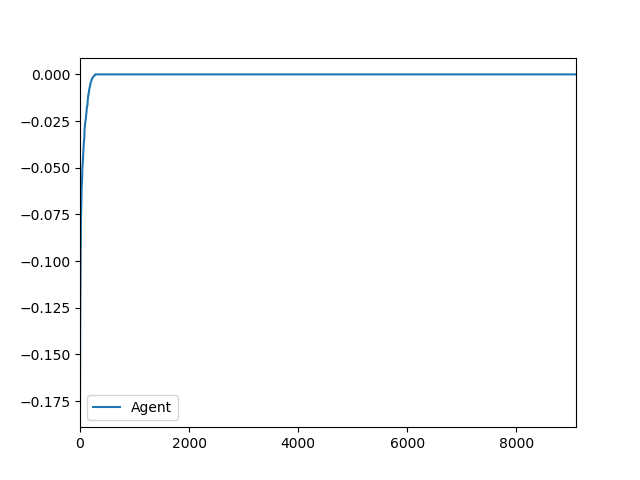

In [38]:
bad_agent[['Agent','No agent']].sort_values(by='Agent').reset_index().plot(y='Agent')

In [24]:
bad_agent[bad_agent['Agent'] < 0].describe()

,Agent,No agent
count,280.000000,280.0
mean,-0.025667,0.0
std,0.031030,0.0
min,-0.180035,0.0
25%,-0.036646,0.0
50%,-0.015012,0.0
75%,-0.003490,0.0
max,-0.000004,0.0


## When is the trained agent struggling? Heavy sun, low sun, low demand?
